# GirlsWhoML Session 5: Convolutional Neural Networks

Authors: Adel Bibi, Catherine Tong

# Utilities

We're going to use a GPU for our exercises today! 

Please do the following: 

1.   Go to `Runtime` on the top menu
2.  `Change runtime type` 
3. Select `GPU` as your `Hardware accelerator`. 



Also run cell below 👇🏻

In [ ]:
from random import randint
import torch, torchvision
from google.colab import files as FILE
import os
import requests                                              
import urllib
import PIL
import matplotlib.pyplot as plt
import cv2
from torch.nn.functional import conv2d
from pathlib import Path
from torchvision.datasets import MNIST
from torchvision.transforms import Normalize
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import time

Run the cell below to start downloading our data for PART 2:

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

str(Path.home())

--2021-07-29 14:32:29--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-07-29 14:32:30--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  11.3MB/s    in 2.9s    

2021-07-29 14:32:33 (11.3 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

'/root'

# Introduction 

Welcome to the last tutorial! 🎉  Previously, we've learned how to implement neural networks in PyTorch. Today, we are going one step further to learn about Convolutional Neural Networks! 



---



# Part 1: Understanding Image Kernels 🕵🏻‍♀


Head to this [tool](https://setosa.io/ev/image-kernels/) and explore the effect of using different kernels on the output image.

Have a go in designing your own kernels! 

💡 *Extension:* have a look online and see if you can apply some well known filters to your image, such as the la placian or the sobel filter. Can you understand why a specific kernel gives a certain result?


**IMPORTANT:** Before you go back to main lecture, make sure you've run all the cells under **Utilities** (top of the notebook), including downloading the data.

# Part 2: Implementing a Convolutional Neural Network 

In this section, you're going to learn how to implement a Convolutional Neural Network (CNN) for a realworld classification task. We will be using the famous **MNIST** Dataset for a **Handwritten Digit Classification** problem! 


Let's first think about what we need:

*   datasets for training and testing
*   a Convolutional Neural Network
*   a loss function and an optimizer
*   a training pipeline that brings everything together

You've seen all of this before, but we'll need to pay special attention to these today:

1. how to load data from MNIST;
2. how to define the CNN in PyTorch;
3. refining the training pipeline

💃💃 Let's begin! 

## Task 2.1 Prepare the data

### Overview

<!-- ![MNIST Dataset](https://miro.medium.com/max/856/0*ut2YGXFia6fMSPHt) -->


Here's something you should know about MNIST:

* **Task**? Classify digits (0 to 9) from an handwritten image;
* **Train / Test splits**? These are pre-defined (60,000 images for training and 10,000 for testing);
* **Size?** Each image is of fixed size (28x28 pixels) and contains one digit at the centre;
* **Values?** Pixel values range from 0 to 255.


### Loading the Data

We've downloaded our data in PART 1, so let's start by loading our image dataset. 

As before, we need `X_data`, `Y_data` as training set, and `X_data_test`, `Y_data_test` as testing set.

In [ ]:
# Run this cell to load the data and define x_train, y_train
data_path = '.'

# train data
train_data = MNIST(data_path, train=True)
X_data_train = train_data.data.float().unsqueeze(1) # we add the channel dimension
Y_data_train = train_data.targets

# test data
test_data = MNIST(data_path, train=False)
X_data_test = test_data.data.float().unsqueeze(1) 
Y_data_test = test_data.targets

We've loaded the data as torch tensors so everything we've covered last session will apply! Can you recognize the channel dimension we added?

In [ ]:
# check the data type
print(type(X_data_train))
# check the data shapes
print(X_data_train.shape, Y_data_train.shape)
print(X_data_test.shape, Y_data_test.shape)

<class 'torch.Tensor'>
torch.Size([60000, 1, 28, 28]) torch.Size([60000])
torch.Size([10000, 1, 28, 28]) torch.Size([10000])


Let's plot some random images from the train dataset:


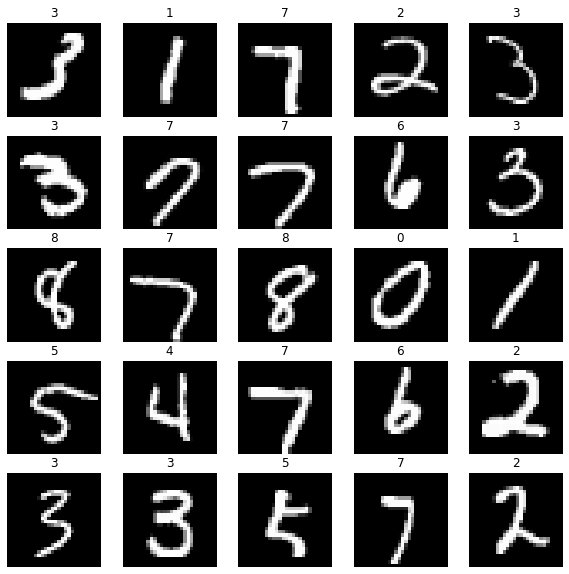

In [ ]:
# Run this cell to visualize random images from the train dataset
plt.figure(figsize=(10,10))

num_images = 25
for i in range(num_images):
  plt.subplot(5,5,i+1)
  idx = randint(0,len(X_data_train)-1)
  plt.imshow(X_data_train[idx,:,:].squeeze(), cmap='gray')
  plt.title(str(Y_data_train[idx].numpy()))
  plt.axis('off')
plt.show()

Great, you've successfully loaded the MNIST data! We can move on to defining the model! 👏

## Task 2.2 Convolutional Layer

You'll recall that fully-connected layers were conveniently implemented as `nn.Linear` in Pytorch.

For Convolutional Layers, it is [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). 

[nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) has some interesting hyperparameters, and we're going to figure out what they mean in this exercise.



### Task 2.2a Dimensions

The input and output of `nn.Conv2d` should be in 4-dimensions: $(N, C, H, W)$, corresponding to (Number images, Channels, Height, Width).

We have $C = 1$ because our images are in grayscale, otherwise $C = 3$ for RGB.

Let's first create some sample data.

In [ ]:
x_sample = X_data_train[:5]
print('input shape: ', x_sample.shape)

input shape:  torch.Size([5, 1, 28, 28])


You can see that the channel dimension is indeed 1 (the dimension we added when loading the data).

Now we can feed this into a convolutional layer!

Play around with its hyperparameters and inspect the difference in output shape! 

In [ ]:
# Try changing these hyperparameters!
out_channels = 8
kernel_size = 3
stride = 1
padding = 0

# define the convolutional layer
my_conv = nn.Conv2d(in_channels=1, # DO NOT CHANGE in_channels, this has to be 1 (grayscale images)
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding)

# pass 
out = my_conv(x_sample)

print('output shape: ', out.shape) # is this the same as our input shape?

output shape:  torch.Size([5, 8, 26, 26])


Discuss with your demonstrator what you think each of these mean:

* Out_channels
* Kernel Size
* Stride
* Padding

💡 **Question:**  How do they affect the output shape? 

*Extension*: In the following figure, can you identify what the [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) parameters are to get the filter pictured in each animation?

<table>
  <tbody>
    <tr>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/full_padding_no_strides.gif"></td>
    </tr>
    <tr>
      <td>No padding, no strides</td>
      <td>Arbitrary padding, no strides</td>
      <td>Half padding, no strides</td>
      <td>Full padding, no strides</td>
    </tr>
    <tr>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif"></td>
      <td><h5><i><b>Source:</b> <a href="https://github.com/vdumoulin/conv_arithmetic">vdumoulin</a></i></h5></td>
    </tr>
    <tr>
      <td>No padding, strides</td>
      <td>Padding, strides</td>
      <td>Padding, strides (odd)</td>
      <td></td>
    </tr>
  </tbody>
</table>

### Task 2.2b Connecting the layers


We often need to have multiple `nn.Conv2d` layers, or, connect a `nn.Conv2d` layer to a `nn.Linear` layer.


#### `nn.Conv2d` --> `nn.Conv2d`

💡 **Question:** Can we just stack two `my_conv` together like this? Why / Why not?

The following shows how you can stack two convolutional layers together: 

In [ ]:
layer1 = nn.Conv2d(in_channels=1,out_channels=10, kernel_size=3)
layer2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3)

print('input shape: ', x_sample.shape)
out_1 = layer1(x_sample)
print('shape after 1st layer: ', out_1.shape)
out_2 = layer2(out_1)
print('shape after 2nd layer: ', out_2.shape)

input shape:  torch.Size([5, 1, 28, 28])
shape after 1st layer:  torch.Size([5, 10, 26, 26])
shape after 2nd layer:  torch.Size([5, 5, 24, 24])


💡 **Question:**  Can you define a third convolutional layer so that we end up with an output shape of $(5, 2, 22, 22)$? 

In [ ]:
# TODO: fill in in_channels and out_channels
# in_channels = ?
# out_channels = ?

in_channels = 5
out_channels = 2
layer3 = nn.Conv2d(in_channels=in_channels, 
                        out_channels=out_channels,
                        kernel_size=3,
                        stride = 1, 
                        padding = 0) # no padding


out_3 = layer3(out_2)
print('shape after 3rd layer: ', out_3.shape) # should print torch.Size([5, 2, 22, 22])

shape after 3rd layer:  torch.Size([5, 2, 22, 22])


#### `nn.Conv2d` --> `nn.Linear`

Let's also consider how we can stack together a convolutional and fully-connected layer. 

Recall their input / output dimensions: 

* `nn.Conv2d`: (N, Channels, Height, Width)
* `nn.Linear`: (N, no. of output features)

We need some way of going from a 4-D tensor (output of `nn.Conv2d`) to a 2-D tensor (input to `nn.Linear` layer), with the first dimension untouched. 

To do this, we need to "flatten" the tensor using [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten), such that $[N, C, H, W]$ --> $[N, C \times H \times W]$. 



In [ ]:
# TODO: change start_dim so that we end up with a tensor of shape (5, 968)

# start_dim = 0 # CHANGE THIS! where should we start flattening the dimensions? 

start_dim = 1

print('original output shape: ', out_3.shape)

# nn.Flatten is implemented as layer, we first define the layer and then apply it
flatten_layer = nn.Flatten(start_dim=start_dim)
out = flatten_layer(out_3)

print('flattened output shape: ', out.shape) # should print torch.Size([5, 968])

original output shape:  torch.Size([5, 2, 22, 22])
flattened output shape:  torch.Size([5, 968])


### Task 2.2c Defining the Network

Last time, we've seen that we can define a neural network with a class like this:  

```
class OneLayerNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.my_layer_1 = nn.Linear(input_dim, output_dim)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        hid1 = self.my_layer_1(x)
        output = self.activation(hid1)
        return output
```

This time is no different! We can now apply what we've learnt about convolutional layers into defining the network.


Let's define a network that has three convolutional layers, followed by a final fully-connected layer for classification.

💡 **Question:** Can you fill in the forward function?

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()

        # convolutional layers
        self.layer1 = nn.Conv2d(input_channels, 10, kernel_size=3)
        self.layer2 = nn.Conv2d(10, 5, kernel_size=3)
        self.layer3 = nn.Conv2d(5, 2, kernel_size=3)
        
        # Linear classifier
        self.flatten = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(968, 10)
        
        # activations
        self.activation = nn.ReLU()

    def forward(self, x):
        # TODO: define your forward pass
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))

        x = self.flatten(x)
        
        output = self.fc(x)

        return output

## Task 2.3 Everything Together

### Task 2.3a Batches

Remember that we now have 60,000 examples in our training set, so we need to use mini-batching to train our network.  

Pytorch provides a [Dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class which allows us to conveniently do this.

In [ ]:
batch_size = 9
train_loader_X = torch.utils.data.DataLoader(dataset=X_data_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

This will automatically generate batches (each with $B$ images) whenever we call the `train_loader_X` as part of a for loop: 

In [ ]:
for batch in train_loader_X:
  print(batch.shape) # should print (batch_size, 1, 28, 28)
  break

torch.Size([9, 1, 28, 28])


💡 **Question:**  In total, how many batches will there be?

In [ ]:
num_train_examples = len(X_data_train)
# TODO: 
num_batches = len(X_data_train) // batch_size
# or int(len(X_data) / batch_size) -- because drop_last = True

print('No. of batches = ', num_batches)
print('This should equal the length of the dataloader, i.e.', len(train_loader_X))

No. of batches =  6666
This should equal the length of the dataloader, i.e. 6666


You've seen how the dataloader works, and now we're going to use the following function to define our training and validation dataloaders.

💡 **Question:** What does `transform_train` do? You might want to look [here](https://pytorch.org/vision/stable/transforms.html) for more info about `torchvision.transforms`, or [here](https://pytorch.org/vision/stable/datasets.html#mnist) about `MNIST`.

In [ ]:
def get_mnist(batch_size=128):
  """ function to make the dataloader for the train and test set

      Returns:
        train_loader: Pytorch dataloader of training data
        test_loader: Pytorch dataloader of testing data

  """

  transform_train = transforms.Compose([
                 #   transforms.RandomCrop(size=28),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
                ])

  # Training dataset
  train_data = MNIST(root='.', train=True, transform=transform_train)

  # Define your data loader with specified batch_size and whether you want to shuffle dataset.
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             pin_memory=True,
                                             drop_last=True)


  transform_test = transforms.Compose([
                    transforms.ToTensor(),
                ])
  # Testing dataset
  test_data = MNIST(root='.', train=False, transform=transform_test)

  # Define your data loader with specified batch_size and whether you want to shuffle dataset.
  test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            pin_memory=True)
  return train_loader, test_loader

In [ ]:
# *** FOR DEMONSTRATORS ***
# RandomCrop, RandomHorizontalFlip: data augmentation mentioned in lecture
# without passing transforms.ToTensor(), we end up with PIL images instead of torch tensors. 
# .ToTensor() changes the range output to be [0,1]
train_data = MNIST(root='.', train=True)
x, y = train_data[0]
print(type(x))
print(type(transforms.ToTensor()(x)))

<class 'PIL.Image.Image'>
<class 'torch.Tensor'>


Now, we can ***inspect*** our dataloader and check that it's giving us the right shapes (this might take a couple of seconds): 

In [ ]:
train_loader, test_loader = get_mnist()

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  print('Batch Index: {}. Batch Shape: {}. Target Size: {}'.format(batch_idx, data.shape, target.shape))
  if batch_idx == 3:
    break

Batch Index: 0. Batch Shape: torch.Size([128, 1, 28, 28]). Target Size: torch.Size([128])
Batch Index: 1. Batch Shape: torch.Size([128, 1, 28, 28]). Target Size: torch.Size([128])
Batch Index: 2. Batch Shape: torch.Size([128, 1, 28, 28]). Target Size: torch.Size([128])
Batch Index: 3. Batch Shape: torch.Size([128, 1, 28, 28]). Target Size: torch.Size([128])


### Task 2.3b Full Training Pipline

Finally, let's bring everything together to define our full training pipeline!

***1.*** Define Dataset + Data Loader (**Done!**)





In [ ]:
train_loader, test_loader = get_mnist(batch_size=128)

***2.*** Define Your network class (**Done in task 2.2c!**)

***3.*** Initialize network, optimizer and all other hyper *parameters* 



Notice below that we need to move our models and tensors to the specified device (the GPU) with `.to(device)`. Things will go wrong if our model and data are not on the same device!

In [ ]:
device = 'cpu' # device name (default is "cpu") even if we did not specify this. The other option is "cuda". We will see this later
input_channels = 1
num_classes = 10 # ten digits 0-9
model = ConvNet(input_channels, num_classes).to(device) # creating an instance of our CNN et voila!

#print a summary of the network
print(model)

# Put a sample through the network and observe the output size
x_sample = x_sample.to(device)
print("Output Size:", model(x_sample).shape)

ConvNet(
  (layer1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (layer2): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (layer3): Conv2d(5, 2, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=968, out_features=10, bias=True)
  (activation): ReLU()
)
Output Size: torch.Size([5, 10])


***4.*** Define Optimizer and Loss function

Just as last time, we'll need to define these. 
We'll again use SGD as our optimizer, but for loss_function we can no longer use the `nn.BCELoss()`, i.e. Binary Cross Entropy (Why?). 

💡 **Task**: Search this [list](https://pytorch.org/docs/stable/nn.html#loss-functions) of loss functions to find an alternative one:


* Hint: it should be of the form `loss_function = nn.YourChosenLoss()`

In [ ]:
# Task find a loss function to represent cross entropy loss

loss_function = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

***5.*** Define the steps for training the network

We can make use of the `take_step` function introduced in our last lecture that trains the model with one batch of data.

💡 **Task**: Modify the function below to  ensure that `model`, `x` and `labels` are located on the same device.

In [ ]:
def take_step(model, loss_function, data, optimizer, device):
    # unpacking our data
    x, labels = data

    # TODO: transfer tensors onto device
    x = x.to(device)
    labels = labels.to(device)

    # Forward pass
    preds = model(x) 

    loss = loss_function(preds, labels) 

    # Backward pass
    # For each parameter PyTorch accumulates gradients in one place, so we need to make sure to initialise them to 0
    optimizer.zero_grad() 

    # Compute the gradient
    loss.backward()

    # take a gradient step
    optimizer.step()

    return model, loss

In one **epoch**, we loop through the entire training dataset to optimize the network. 

💡 **Task**: Complete the code below.

In [ ]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_function, device, print_freq):
  
  model = model.train()

  for batch_idx, data in enumerate(train_loader):
      # TO-DO: call the take_step function  
      model, loss = take_step(model, loss_function, data, optimizer, device)

      # report progress
      if batch_idx % print_freq == 0:
          print(
              '+ Epoch: {}. Iter: [{}/{} ({:.0f}%)]. Loss: {:.5f}.'
              .format(
                  epoch,
                  batch_idx * len(data[0]),
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss / len(data[0]),
              ),
              flush=True)

***6.*** Monitoring test performance

We would also like to monitor the test (or validation) performance as we're training the network, and we define this function to do that:

In [ ]:
def eval_test(model, test_loader, loss_function, epoch, device):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data in test_loader:
          x, labels = data

          # Move data and labels onto device
          x = x.to(device)
          labels = labels.to(device)

          # Forward pass
          logits = model(x)

          # Accumulate test loss over all samples
          test_loss += loss_function(logits, labels).item()

          #  Monitor number of correctly classified samples
          correct += (logits.max(1)[1] == labels).sum().item()

    # compute average loss
    test_loss /= len(test_loader.dataset)

    # compute total accuracy
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # printing
    print('Test: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f})%)'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy)
        )
    return test_loss, test_accuracy


***7.*** Loop over number of epochs to train your network!

In [ ]:
epoch_init = 0
num_epochs = 5
for epoch in range(epoch_init, num_epochs):
  start = time.time()
  train_one_epoch(epoch, model, train_loader, optimizer, loss_function, device, 100)
  end = time.time()
  print("Time to process one full epoch: {:.3f} seconds".format(end - start))
  eval_test(model, test_loader, loss_function, epoch, device)

+ Epoch: 0. Iter: [0/60000 (0%)]. Loss: 0.01801.
+ Epoch: 0. Iter: [12800/60000 (21%)]. Loss: 0.01799.
+ Epoch: 0. Iter: [25600/60000 (43%)]. Loss: 0.01797.
+ Epoch: 0. Iter: [38400/60000 (64%)]. Loss: 0.01798.
+ Epoch: 0. Iter: [51200/60000 (85%)]. Loss: 0.01798.
Time to process one full epoch: 22.520 seconds
Test: Average Loss: 0.0182, Accuracy: 1135/10000 (11)%)
+ Epoch: 1. Iter: [0/60000 (0%)]. Loss: 0.01797.
+ Epoch: 1. Iter: [12800/60000 (21%)]. Loss: 0.01798.
+ Epoch: 1. Iter: [25600/60000 (43%)]. Loss: 0.01798.
+ Epoch: 1. Iter: [38400/60000 (64%)]. Loss: 0.01798.
+ Epoch: 1. Iter: [51200/60000 (85%)]. Loss: 0.01797.
Time to process one full epoch: 21.507 seconds
Test: Average Loss: 0.0182, Accuracy: 1135/10000 (11)%)
+ Epoch: 2. Iter: [0/60000 (0%)]. Loss: 0.01797.
+ Epoch: 2. Iter: [12800/60000 (21%)]. Loss: 0.01800.
+ Epoch: 2. Iter: [25600/60000 (43%)]. Loss: 0.01797.
+ Epoch: 2. Iter: [38400/60000 (64%)]. Loss: 0.01799.
+ Epoch: 2. Iter: [51200/60000 (85%)]. Loss: 0.01800.

Notice how slow the training is. How about speeding up significantly with minimal code changes? As we set our hardware acceleration to 'GPU' at the beginning of the notebook, we can now use this to speed up our code! Follow the simple two steps below to change training from the CPU to the GPU. 

1. Make sure you change the `device="cpu"` to `device="cuda"` as below.
2. Rerun your code again and enjoy acceleration 💃💃💃💃💃



In [ ]:
device = 'cuda' # or change to 'cpu' if encounter RuntimeError: No CUDA GPUs are available
model = ConvNet(input_channels=1, num_classes=10).to(device) # creating an instance of our CNN et voila!

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

epoch_init = 0
num_epochs = 5
for epoch in range(epoch_init, num_epochs):
  start = time.time()
  train_one_epoch(epoch, model, train_loader, optimizer, loss_function, device, 100)
  end = time.time()
  print("Time to process one full epoch: {:.3f} seconds".format(end - start))
  eval_test(model, test_loader, loss_function, epoch, device)

+ Epoch: 0. Iter: [0/60000 (0%)]. Loss: 0.01798.
+ Epoch: 0. Iter: [12800/60000 (21%)]. Loss: 0.01796.
+ Epoch: 0. Iter: [25600/60000 (43%)]. Loss: 0.01801.
+ Epoch: 0. Iter: [38400/60000 (64%)]. Loss: 0.01796.
+ Epoch: 0. Iter: [51200/60000 (85%)]. Loss: 0.01794.
Time to process one full epoch: 6.488 seconds
Test: Average Loss: 0.0182, Accuracy: 982/10000 (10)%)
+ Epoch: 1. Iter: [0/60000 (0%)]. Loss: 0.01804.
+ Epoch: 1. Iter: [12800/60000 (21%)]. Loss: 0.01798.
+ Epoch: 1. Iter: [25600/60000 (43%)]. Loss: 0.01798.
+ Epoch: 1. Iter: [38400/60000 (64%)]. Loss: 0.01797.
+ Epoch: 1. Iter: [51200/60000 (85%)]. Loss: 0.01794.
Time to process one full epoch: 6.299 seconds
Test: Average Loss: 0.0182, Accuracy: 982/10000 (10)%)
+ Epoch: 2. Iter: [0/60000 (0%)]. Loss: 0.01798.
+ Epoch: 2. Iter: [12800/60000 (21%)]. Loss: 0.01797.
+ Epoch: 2. Iter: [25600/60000 (43%)]. Loss: 0.01806.
+ Epoch: 2. Iter: [38400/60000 (64%)]. Loss: 0.01793.
+ Epoch: 2. Iter: [51200/60000 (85%)]. Loss: 0.01800.
Tim

Can you now observe the difference in training time between 'cpu' and 'gpu' training? 

# Extensions 🚀



If you're keen to practise more, read on for  some suggestions from us :)

## How to improve your model performance?

**Optimize model architecture**
*   Add max-pool layers between convolutional layers
*   Add additional convolutional layers
*   Add more fc layers
*   Use developed model architectures from the literature (i.e. VGGnet, ResNet)

**Optimize training**
*   Use a different optimizer (i.e. Adam instead of SGD)
*   Change the learning rate 
*   Train for more epochs
*    Change loss (dependant on task)










## Alternate dataset: Fashion-MNIST

[List of all available datasets in pytorch](https://pytorch.org/vision/0.8/datasets.html)

**Classes of Fashion-MNIST**
*   0: T-shirt/top
*   1: Trouser
*   2: Pullover
*   3: Dress
*   4: Coat
*   5: Sandal
*   6: Shirt
*   7: Sneaker
*   8: Bag
*   9: Ankle boot

In [ ]:
from pathlib import Path

from torchvision.datasets import FashionMNIST

data_path = Path.home() / './FashionMNIST'

# Load dataset
train_fashionmnist = FashionMNIST(data_path, train=True, download=True)
x_train = train_fashionmnist.data.float()
y_train = train_fashionmnist.targets

test_fashionmnist = FashionMNIST(data_path, train=False, download=True)
x_test = test_fashionmnist.data.float()
y_test = test_fashionmnist.targets


Extracting /root/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/FashionMNIST/FashionMNIST/raw




Extracting /root/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/FashionMNIST/FashionMNIST/raw




Extracting /root/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/FashionMNIST/FashionMNIST/raw




Extracting /root/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/FashionMNIST/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


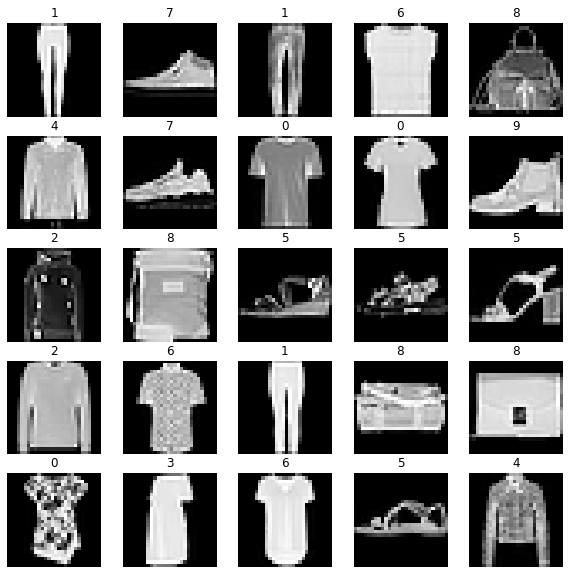

In [ ]:
from random import randint
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,10)) # specifying the overall grid size

num_images = 25
for i in range(num_images):
  plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
  idx = randint(0,len(x_train)-1)
  plt.imshow(x_train[idx,:,:].squeeze(), cmap='gray')
  plt.title(str(y_train[idx].numpy()))
  plt.axis('off')
plt.show()